In [2]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score, confusion_matrix
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *
from models.rotnet.rotnet import *
from models.rotnet.IDEC import *
from cluster_accuracy import cluster_accuracy

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.8.1+cu111
torchvision: 0.9.1+cu111
numpy: 1.19.5
scikit-learn: 0.24.1
Using device:  cuda


In [5]:
# specify learning params
batch_size = 128
learning_rate = 0.001
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


In [6]:
rotnet = load_model('pretrained_RotNet_features.pth', device)

In [7]:
data = load_util.load_custom_cifar('./data', download=False, data_percent=data_percent, for_model=None)
train_loader = torch.utils.data.DataLoader(data,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [8]:
rotnet_dec = IDEC(rotnet, train_loader, device)

In [10]:
base_path = "trained_models"
pretrained_model_name = f"{rotnet_dec.name}.pth"
pretrained_model_path = os.path.join(base_path, pretrained_model_name)

In [11]:
pretrained_model_path

'trained_models\\DEC_RotNet.pth'

In [23]:
rotnet_dec.fit(train_loader, epochs=50, start_lr=0.001, device=device, model_path=pretrained_model_path, write_stats=True)

DEC_RotNet: Epoch 1/50 - Iteration 156 - Train loss:2.2890, LR: 0.0001
DEC_RotNet: Epoch 6/50 - Iteration 936 - Train loss:2.2884, LR: 0.0001
DEC_RotNet: Epoch 11/50 - Iteration 1716 - Train loss:2.2871, LR: 0.0001
DEC_RotNet: Epoch 16/50 - Iteration 2496 - Train loss:2.2857, LR: 0.0001
DEC_RotNet: Epoch 21/50 - Iteration 3276 - Train loss:2.2831, LR: 0.0001
DEC_RotNet: Epoch 26/50 - Iteration 4056 - Train loss:2.2852, LR: 0.0001
DEC_RotNet: Epoch 31/50 - Iteration 4836 - Train loss:2.2838, LR: 0.0001
DEC_RotNet: Epoch 36/50 - Iteration 5616 - Train loss:2.2852, LR: 0.0001
DEC_RotNet: Epoch 41/50 - Iteration 6396 - Train loss:2.2819, LR: 0.0001
DEC_RotNet: Epoch 46/50 - Iteration 7176 - Train loss:2.2825, LR: 0.0001


TypeError: cannot unpack non-iterable NoneType object

In [24]:
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(rotnet_dec, rotnet_dec.name, colors_classes, device, testloader)

DEC_RotNet
Starting encoding...
Starting KMeans...
Starting PCA...


<AxesSubplot:title={'center':'DEC_RotNet Cluster Accuracy: 0.3859'}>

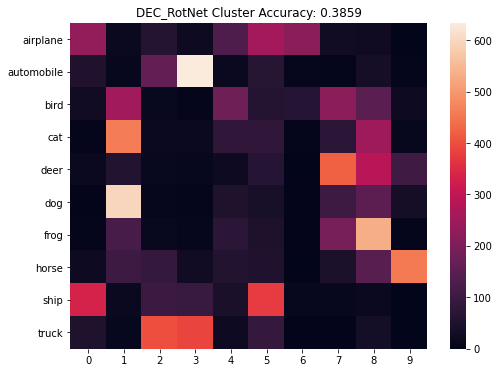

In [29]:
fig, axes = plt.subplots(figsize=(8,6))
rotnet_ca = cluster_accuracy(labels, kmeans.labels_)
cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
axes.set(title=f'{rotnet_dec.name} Cluster Accuracy: {rotnet_ca:.4f}')
sns.heatmap(cm, yticklabels=test_data.classes, ax=axes)

### Clustering and PCA of the pretrained RotNet model 

In [16]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0, for_model='SimCLR')
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=False)

In [17]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [9]:
# for i in range(3):
model = RotNet(num_classes=4)

state_dict = torch.load(f'trained_models/pretrained_RotNet_features.pth', map_location='cpu')
model.load_state_dict(state_dict)
model.to(device)

print(model.feat_block_names)

['conv1', 'conv2', 'conv3', 'pooling', 'features', 'classifier']


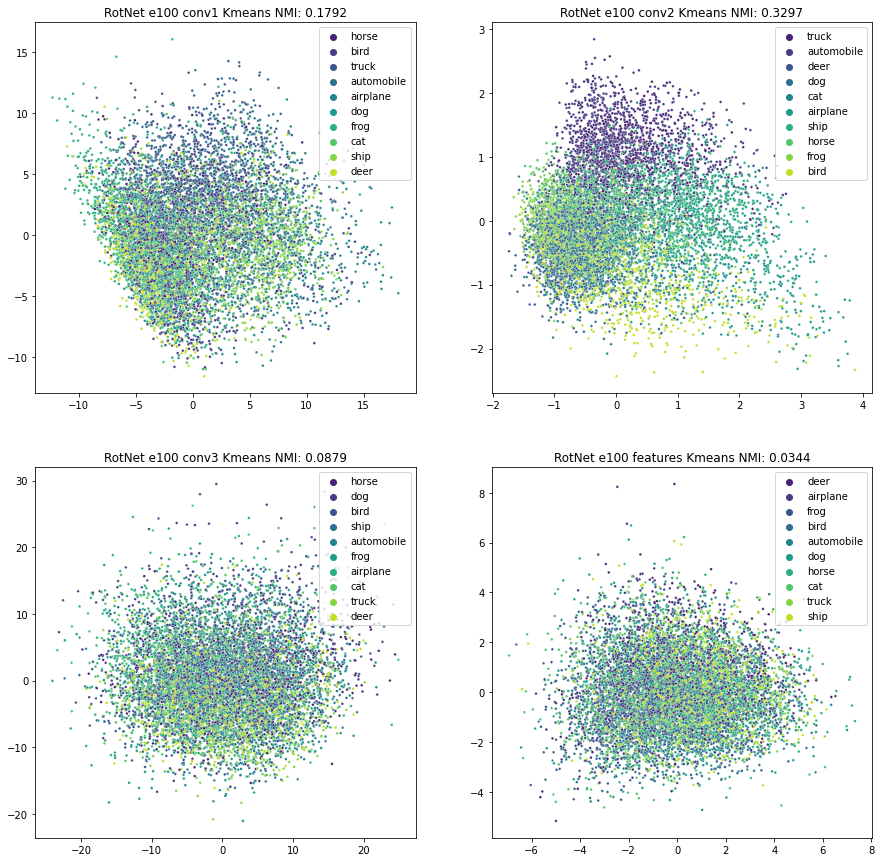

In [85]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    ver = f'RotNet e100 {layer}'
    embedded_data, labels = encode_batchwise(testloader, model, device, [layer], flatten=True)
    lable_classes=[colors_classes[l] for l in labels]

    n_clusters = len(set(labels))
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedded_data)
    nmi = normalized_mutual_info_score(labels, kmeans.labels_)

    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(embedded_data)

    axes[i].set_title(f'{ver} Kmeans NMI: {nmi:.4f}')
    sns.scatterplot(ax=axes[i], x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

### RotNet IDEC

In [37]:
name = 'IDEC_RotNet_e100_features.pth'
rotnet = load_model(name, device, torch.rand(size=(4, 10)))

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...
IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...
IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...
IDEC_RotNet_e100_features.pth
Starting encoding...
Starting KMeans...
Starting PCA...


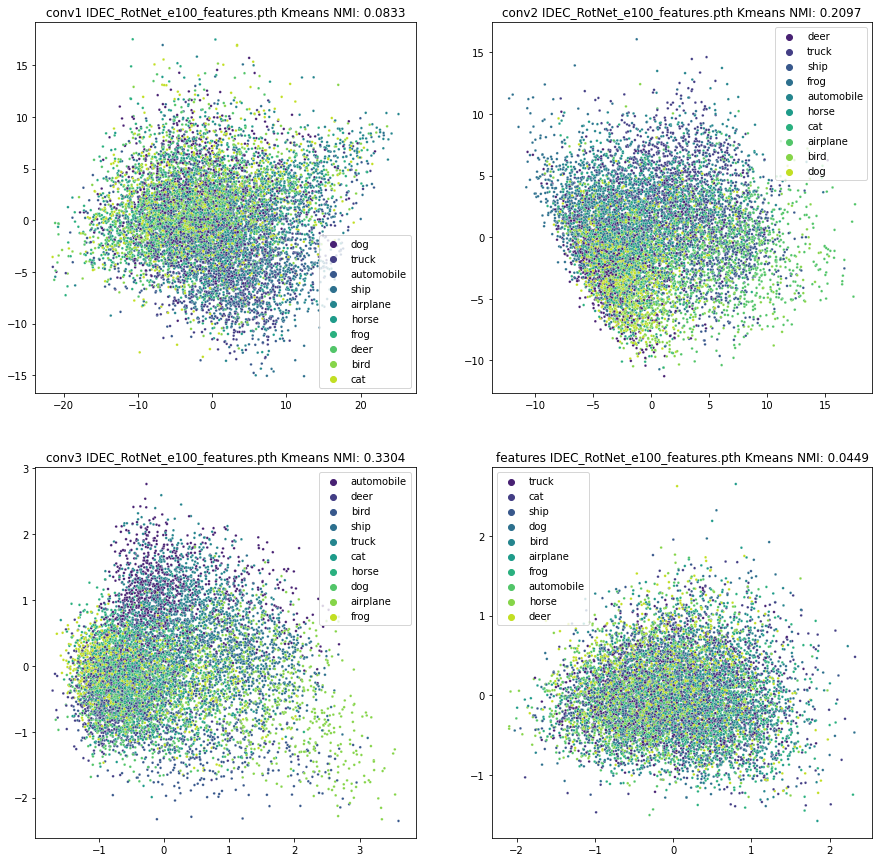

In [32]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    flatten = 'conv' in layer
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer=layer,
                                                        flatten=flatten)
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmi, pca, lable_classes)

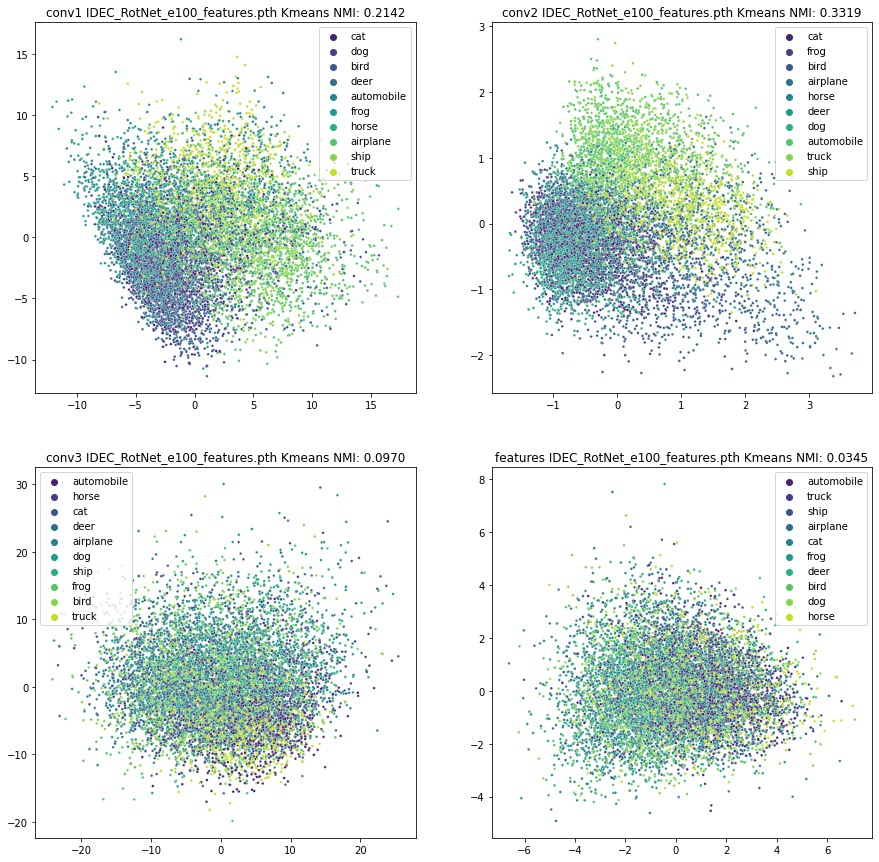

In [38]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()
layers = ['conv1', 'conv2', 'conv3', 'features']

for i, layer in enumerate(layers):
    flatten = 'conv' in layer
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer=layer,
                                                        flatten=flatten)
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmi, pca, lable_classes)

In [25]:
names = ['pretrained_RotNet_features.pth', 'IDEC_RotNet_e100_features.pth']
pcas = {}
nmis = {}

In [ ]:
for name in names:
    rotnet = load_model(name, device, torch.rand(size=(4, 10)))
    _, _, nmi, pca, lable_classes = compute_nmi_and_pca(rotnet,
                                                        name,
                                                        colors_classes,
                                                        device,
                                                        testloader,
                                                        layer='features',
                                                        flatten=False)
    pcas[name] = pca
    nmis[name] = nmi

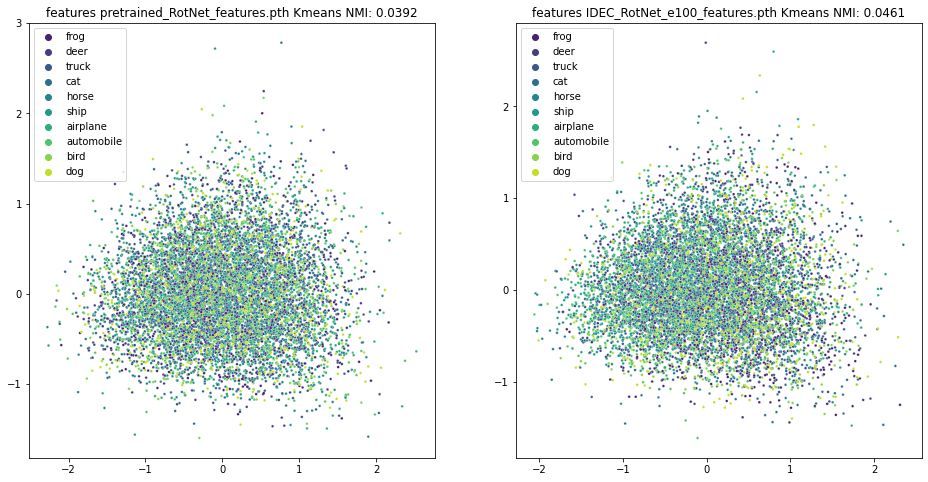

In [31]:
fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes = axes.flatten()

for i, name in enumerate(names):
    plot_pca_and_nmi(f'{layer} {name}', axes[i], nmis[name], pcas[name], lable_classes)

As we have discussed last Friday, I have tried to add an additional linear layer with 10 output dimensions, but as we see, clustering based on features was not really successful. I have read the paper again and have noticed the following: they also pretrain the model to get relevant features, and then use the output from one of the inner convolutional layers (2d is the best) to train a classifier in a supervised way, so they use the true labels. 

So I kind of have a problem here: I either need to use true labels to continue training with cross entropy, because cross entropy loss needs some kind of labels, or I can use some other loss which would make sense with convolution network output activations as input.

But since I could not perform IDEC, I decided to try to perform DEC to see what will happen, because in case of DEC I don't need a model's training loss and because I thought that probably in case where we don't really have "reconstruction" of the images the distortion of the features won't be that bad.

pretrained_RotNet_features.pth class representation


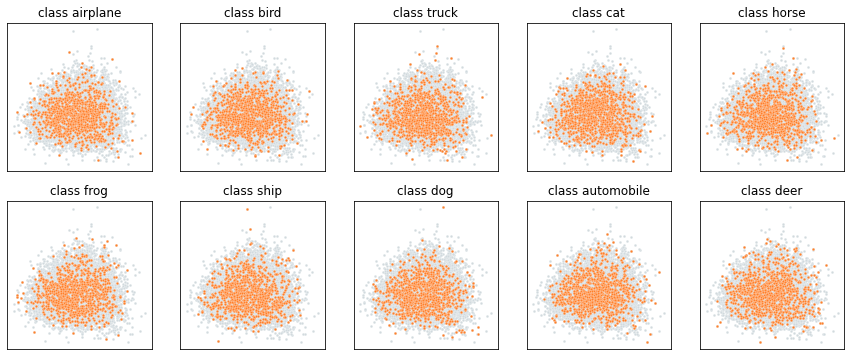

IDEC_RotNet_e100_features.pth class representation


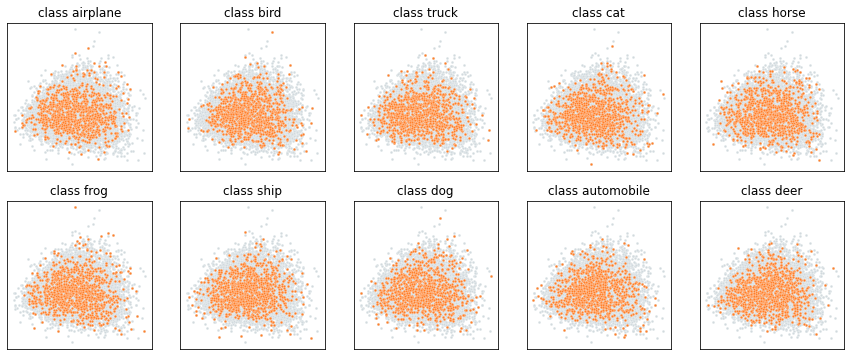

In [34]:
for name in names:
    plot_class_representation(pcas[name], name, lable_classes)

### RotNet DEC

In [ ]:
name = 'DEC_RotNet_50.pth'
rotnet = load_model(name, device)

In [ ]:
labels, kmeans, nmi, reduced_data, lable_classes = compute_nmi_and_pca(rotnet, name, colors_classes, device, testloader)

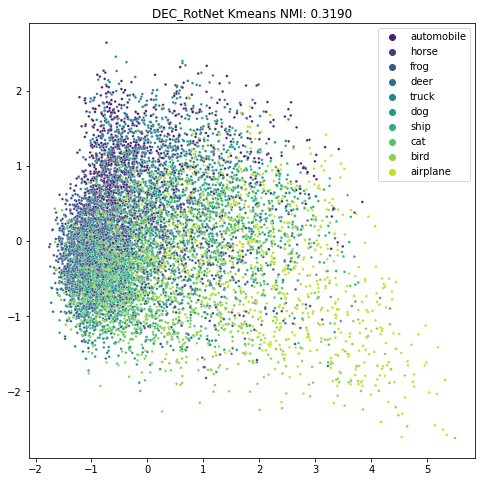

In [20]:
fig, axes = plt.subplots(figsize=(8,8))
plot_pca_and_nmi(rotnet_dec.name, axes, nmi, reduced_data, lable_classes)

DEC_RotNet class representation


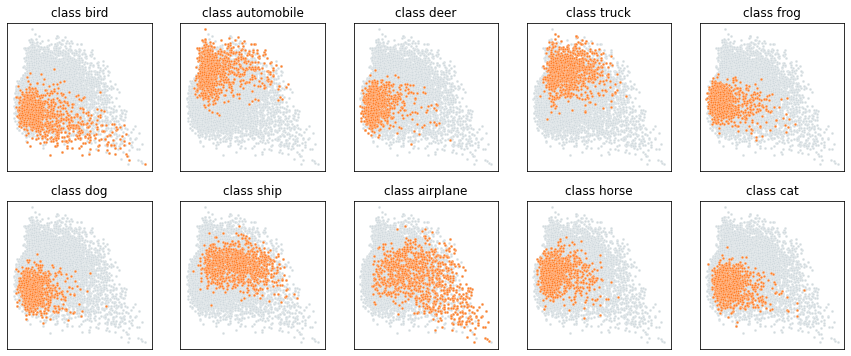

In [22]:
plot_class_representation(reduced_data, rotnet_dec.name, lable_classes)

## Cluster accuracy and Confusion Matrix

In [33]:
names = ['pretrained_RotNet_features.pth', 'DEC_RotNet.pth']

D:\everything\Studium\WS2020\Bachelor\dcl_b\models\dec\DEC.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.centers = torch.nn.Parameter(torch.tensor(init_np_centers), requires_grad=True)


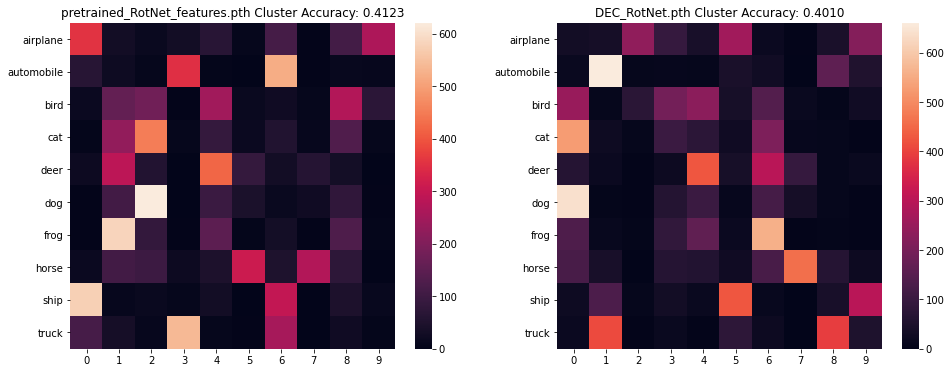

In [39]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

for i, name in enumerate(names):
    model = load_model(name, device)
    labels, kmeans, _, _, lable_classes = compute_nmi_and_pca(model, name, colors_classes, device, testloader)
    rotnet_ca = cluster_accuracy(labels, kmeans.labels_)
    cm = confusion_matrix(labels, kmeans.labels_, labels=list(range(len(test_data.classes))), normalize=None)
    axes[i].set(title=f'{name} Cluster Accuracy: {rotnet_ca:.4f}')
    sns.heatmap(cm, yticklabels=test_data.classes, ax=axes[i])